# Poissonaeity Testing

Testing tests for poissoneity from a variety of sources. (n.b. As far as I can tell, "poissonaeity" is not actually an English word. I'm using it as shorthand for "likelihood that events were drawn from a Poissonian process".)

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import display

%autoreload 2
import poisson_test

pd.options.display.float_format = lambda x: '%.2g' % x

The mean event count (the product of the mean activity rate and the duration) often ends up being the number of degrees of freedom in a chi-squared type test, which is why these parameters are the most critical part in the setup.

In [3]:
mean_rate = 10  # average activity rate per time interval
duration = 100  # time intervals, could be days or years

In [4]:
# define some functions useful for testing our Poissoneity tests
def variable_poissonian(rate_function, duration):
    """
    Generates event times between zero and `duration` with exponentially 
    distributed wait times where the mean rate is defined by a
    `rate_function`.
    """

    # find first event after an unrecorded one at t=0
    times = [np.random.exponential(1./rate_function(0))]
    
    # relocate start time between t=0 and first event using uniform distribution
    times[0] *= np.random.random()
    
    # keep generating events until the duration has passed
    while times[-1] < duration:
        times += [times[-1] + np.random.exponential(1./rate_function(times[-1]))]

    # throw away the extra event
    return np.array(times[:-1])


def fading_poissonian(mean_activiy_rate, duration, fade_start, fade_end, fade_factor):
    """
    Simulate the loss of randomly selected events in a given time window
    from a set which is otherwise exponentially distributed.
    """
    
    # generate way more events than needed
    times = 1/mean_activiy_rate*np.random.exponential(1, 2*mean_count).cumsum()
    
    # relocate start time between t=0 and first event using uniform distribution
    times -= times[0]*np.random.random()
    
    # get rid of extra events
    times = times[times < duration]
    
    # apply time-localized dropping of events
    fade_out = (times >= fade_start) & (times < fade_end)
    missed = np.random.random_sample(len(times)) < fade_factor       
    return times[~fade_out | ~missed]   

In [5]:
# generate some test catalogs
mean_count = int(mean_rate*duration)  # average number of events in duration
time_range = (0, duration)

# many of the simulated catalogs have a common period where rates are perturbed
perturb_duration = int(duration/10)
perturb_start = int(duration/2 - perturb_duration/2)
perturb_end = int(duration/2 + perturb_duration/2)

log_sigma = 0.25

t = []
labels = []

# exponentially distributed wait times
times = 1/mean_rate*np.random.exponential(1, 2*mean_count).cumsum()
t.append(times[times < duration])
labels.append('exponential recurrence')

# uniformly distributed times
times = duration*np.random.random_sample(mean_count)
t.append(np.sort(times))
labels.append('uniform occurrence')

# log-normally distributed wait times
times = (10**np.random.normal(loc=np.log10(1/mean_rate), 
                              scale=log_sigma, size=2*mean_count)).cumsum()
t.append(times[times < duration])
labels.append('log-normal recurrence')

# exponentially distributed wait times, with changing rate
f = lambda t: 5*mean_rate if ((t >= perturb_start) and 
                            (t < perturb_end)) else mean_rate
t.append(variable_poissonian(f, duration))
labels.append('5x rate period')
         
f = lambda t: 2*mean_rate if ((t >= perturb_start) and 
                            (t < perturb_end)) else mean_rate
t.append(variable_poissonian(f, duration))
labels.append('2x rate period')

f = lambda t: 0.5*mean_rate if ((t >= perturb_start) and 
                            (t < perturb_end)) else mean_rate
t.append(variable_poissonian(f, duration))
labels.append('1/2 rate period')

f = lambda t: 0.2*mean_rate if ((t >= perturb_start) and 
                            (t < perturb_end)) else mean_rate
t.append(variable_poissonian(f, duration))
labels.append('1/5 rate period')

# fading out of detection capability
t.append(fading_poissonian(mean_rate, duration, perturb_start, perturb_end, 0.5))
labels.append('50% fade')

t.append(fading_poissonian(mean_rate, duration, perturb_start, perturb_end, 0.8))
labels.append('80% fade')

t.append(fading_poissonian(mean_rate, duration, perturb_start, perturb_end, np.inf))
labels.append('outage')

In [6]:
# zoom until we have some reasonable number of events in the outage series
def zoom_limits(time_range, zoom):
    mid_time = (max(time_range) + min(time_range))/2.
    duration = max(time_range) - min(time_range)
    return (mid_time - zoom*duration/2, mid_time + zoom*duration/2)

def count_zoomed(t, time_range, zoom):
    limits = zoom_limits(time_range, zoom)
    return sum((t > limits[0]) & (t < limits[1]))

zoom = 1
index = [i for i, label in enumerate(labels) if label == 'outage'][0]
while count_zoomed(t[index], time_range, zoom) > 200:
    zoom /= 2.
time_limits = zoom_limits(time_range, zoom)
display(time_limits)

(37.5, 62.5)

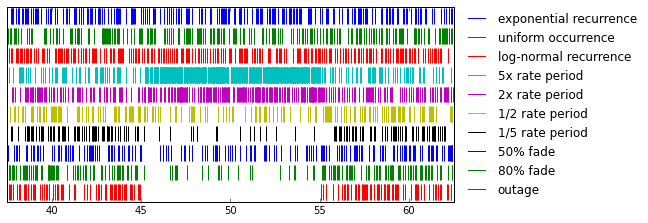

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
for i, (times, label) in enumerate(zip(t, labels)):
    plt.vlines(times, -(i + 0.1)*np.ones_like(times), -(i + 0.9)*np.ones_like(times), 
               label=label, color=next(ax._get_lines.color_cycle))
plt.xlim(time_limits)
plt.yticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

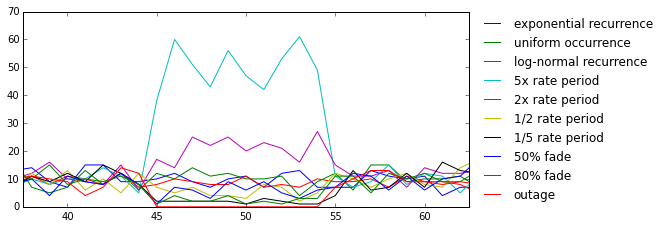

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
for times, label in zip(t, labels):
    counts = poisson_test.count_events(times, time_range)[0]
    plt.plot(counts, label=label)
plt.xlim(time_limits)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

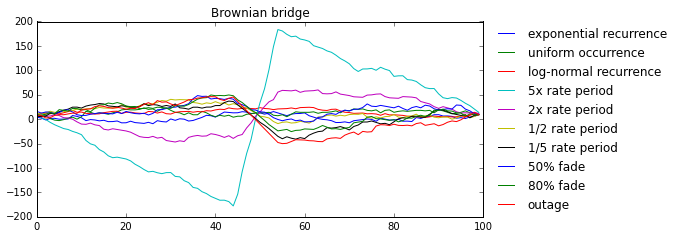

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
for times, label in zip(t, labels):
    counts = poisson_test.count_events(times, time_range)[0]
    trend = np.arange(len(counts))*np.sum(counts)/len(counts)
    plt.plot(np.cumsum(counts) - trend, label=label)
    
plt.title('Brownian bridge')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

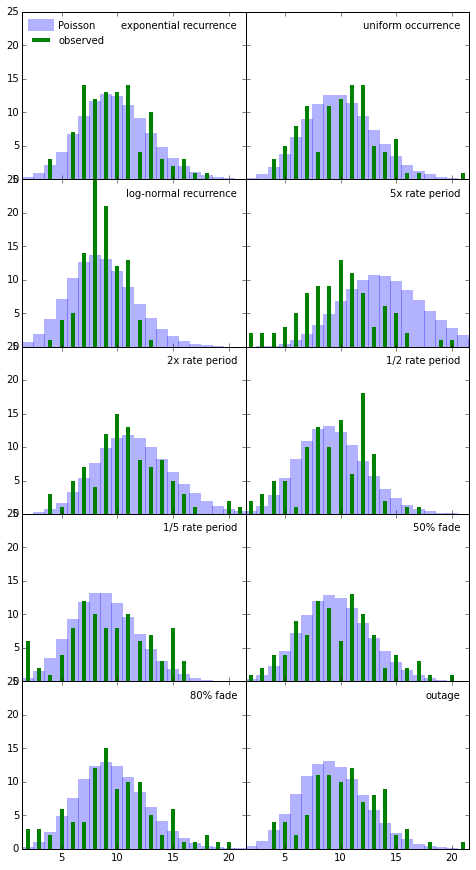

In [10]:
num_rows = int(np.ceil(len(labels)/2))
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, 
                         figsize=(4*num_cols, 3*num_rows), 
                         sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

for times, label, ax in zip(t, labels, axes.ravel()[:len(labels)]):
    fig.sca(ax)
    poisson_test.annotate(label, 'upper right')
    poisson_test.plot_histogram(times, time_range)

count_limits = (np.floor(stats.poisson.ppf(0.001, mean_rate)), 
                np.ceil(stats.poisson.ppf(0.999, mean_rate)))
axes[0, 0].set_xlim(count_limits[0] - 0.5, count_limits[1] + 0.5)
axes[0, 0].legend(loc='upper left', frameon=False, fontsize=10);

In [11]:
# use everything we've got to test the data
verbose = False
print "Poisson dispersion test: DT"
p_DT = pd.Series([poisson_test.dispersion(
            times, time_range, verbose=verbose) 
        for times in t], name='DT')

print "Brown-Zhao test: BZ"
p_BZ = pd.Series([poisson_test.brown_zhao(
            times, time_range, verbose=verbose) 
        for times in t], name='BZ')

print "Kolmogorov-Smirnov exponential (using a priori mean): KSE"
p_KSE = pd.Series([poisson_test.kolmogorov_smirnov(
            times, time_range, 'expon', mean_wait=1/mean_rate,  verbose=verbose) 
         for times in t], name='KSE')

print "Kolmogorov-Smirnov exponential (no a priori knowledge): KSE'"
p_KSE2 = pd.Series([poisson_test.kolmogorov_smirnov(
            times, time_range, 'expon', verbose=verbose) 
         for times in t], name="KSE'")

print "Kolmogorov-Smirnov uniform: KSU"
p_KSU = pd.Series([poisson_test.kolmogorov_smirnov(
            times, time_range, 'uniform', verbose=verbose) 
         for times in t], name='KSU')

print "Combine using Fisher's method: all, w/o BZ"
p_all = pd.Series(poisson_test.combine_pvalues((p_DT, p_BZ, p_KSE2, p_KSU)), name='all')
p_wo_BZ = pd.Series(poisson_test.combine_pvalues((p_DT, p_KSE2, p_KSU)), name='w/o BZ')

label_series = pd.Series(labels, name='Test')
events = pd.Series([len(times) for times in t], name='events')
activity_rates = pd.Series([len(times)/duration for times in t], name='activity rates')

Poisson dispersion test: DT
Brown-Zhao test: BZ
Kolmogorov-Smirnov exponential (using a priori mean): KSE
Kolmogorov-Smirnov exponential (no a priori knowledge): KSE'
Kolmogorov-Smirnov uniform: KSU
Combine using Fisher's method: all, w/o BZ


In [12]:
df_poisson = pd.concat([label_series, events, activity_rates, 
                        p_DT, p_BZ, p_KSE, p_KSE2, p_KSU, p_all, p_wo_BZ], axis=1)

print('Summary of p-values mean of %g events in %d intervals for mean of %g per interval:' %
      (duration*mean_rate, duration, mean_rate))
print('results near 1 indicate null hypothesis (Poissonian) likely true')
df_poisson.sort(columns="w/o BZ", ascending=False)

Summary of p-values mean of 1000 events in 100 intervals for mean of 10 per interval:
results near 1 indicate null hypothesis (Poissonian) likely true


,Test,events,activity rates,DT,BZ,KSE,KSE',KSU,all,w/o BZ
1,uniform occurrence,1000,10,0.39,0.0033,0.83,0.83,0.98,0.09,0.89
0,exponential recurrence,982,9.8,0.82,1,0.23,0.51,0.68,0.96,0.87
5,1/2 rate period,928,9.3,0.33,3.2e-83,0.14,0.7,0.17,1.5e-78,0.36
7,50% fade,966,9.7,0.003,0,0.91,0.64,0.083,0,0.0076
8,80% fade,950,9.5,1.3e-05,0,0.87,0.39,0.042,0,2.8e-05
4,2x rate period,1151,12,9.8e-06,0,9.8e-05,0.25,0.004,0,1.8e-06
6,1/5 rate period,893,8.9,3.7e-06,0,0.47,0.016,0.0054,0,8.5e-08
9,outage,933,9.3,1.3e-09,0,0.11,0.0008,0.00088,0,5.9e-13
2,log-normal recurrence,865,8.7,1,1,0,0,0.87,0,0
3,5x rate period,1388,14,4.3e-181,0,0,0,0,0,0


It is truly remarkable how this suite of tests disagrees on the particulars, yet using Fisher's method to combine them gives a robust overall result.

Examples:
1. Uniform sometimes passes all but BZ.
1. Log-normal sometimes passes all but KSE'.
1. Variable-rate periods sometimes pass all but BZ or KSE.
1. An outage seems to be one of the hardest types of non-Poisson behaviour to detect, but KSU tends to give consistently low p-values.
1. When the activity rate is near or below unity BZ performs poorly, giving all false-positives. One could argue that this just means the time bin needs to be larger, but in this regime DT consistently performs better and is just as reliant on binning.

Concerns:
1. All of the above observations are made on the basis of a few runs with a different configuration. In fact what needs to be done is to do many runs with many configurations and summarize the statistics of the results.
1. All methods perform poorly for event counts < 50.
1. Brown-Zhao seems over-sensitive, i.e. strongly tending to 1 and 0. I'm not sure this is a candidate for combination using Fisher's method.


In [13]:
# load application of same metrics to real catalogues from Indian subcontinent
df_poisson = pd.read_csv('MostPoissonianSubcatalogues.csv', index_col=0)
display(df_poisson)

,best catalogue,layerid,min mag,start,events,years,activity rate,DT,BZ,KSE',KSU,all,w/o BZ
0,declustered mainshocks,1,4.5,1964,3441,45,76,2e-118,0,8.5e-08,9.4e-79,0,1.7e-198
1,declustered raw,1,5.5,1903,621,106,5.9,3.8e-76,0,6.6e-11,0,0,0
2,declustered mainshocks,1,5,1964,1510,45,34,1.2e-27,0,0.0027,1.8e-05,0,1.9e-31
3,declustered mainshocks,1,6,1964,153,45,3.4,6.2e-15,1.2e-196,0.13,0.00034,7.2e-208,2.7e-16
4,declustered mainshocks,2,4.5,1964,3779,45,84,6.7e-38,0,0.00086,3.4e-18,0,1.8e-54
5,declustered mainshocks,2,5.5,1902,461,107,4.3,1e-34,0,1.1e-10,2.1e-11,0,1.9e-51
6,mainshocks,2,5,1964,1267,45,28,6e-11,0,0.00057,5.3e-08,0,2.1e-18
7,mainshocks,2,6,1964,59,45,1.3,0.081,0.85,0.88,0.0091,0.059,0.023
8,mainshocks,3,4.5,1964,1993,45,44,4.2e-29,0,0.0043,2.6e-05,0,1.6e-32
9,declustered mainshocks,3,5.5,1914,131,95,1.4,0.0012,8.1e-83,0.041,1.7e-06,1.1e-86,2.5e-08


In [14]:
display(df_poisson.sort(columns='w/o BZ', ascending=False))

,best catalogue,layerid,min mag,start,events,years,activity rate,DT,BZ,KSE',KSU,all,w/o BZ
11,declustered raw,3,6,1964,26,45,0.58,0.65,1,0.85,0.88,0.99,0.96
15,declustered raw,4,6,1984,11,25,0.44,0.78,1,0.6,0.72,0.97,0.9
13,declustered mainshocks,4,5.5,1912,81,97,0.84,0.65,1,0.53,0.29,0.79,0.59
7,mainshocks,2,6,1964,59,45,1.3,0.081,0.85,0.88,0.0091,0.059,0.023
14,mainshocks,4,5,1984,96,25,3.8,0.00016,8.8e-44,0.78,0.0034,9.4e-45,5.2e-05
9,declustered mainshocks,3,5.5,1914,131,95,1.4,0.0012,8.1e-83,0.041,1.7e-06,1.1e-86,2.5e-08
10,mainshocks,3,5,1964,596,45,13,6.5e-06,0,0.0015,5.5e-05,0,2.2e-10
3,declustered mainshocks,1,6,1964,153,45,3.4,6.2e-15,1.2e-196,0.13,0.00034,7.2e-208,2.7e-16
6,mainshocks,2,5,1964,1267,45,28,6e-11,0,0.00057,5.3e-08,0,2.1e-18
12,declustered raw,4,4.5,1984,141,25,5.6,2.8e-15,0,0.027,5.8e-07,0,6.1e-20


Note that only the best (highest p-value) result from the catalogues were retained, the catalogues being:

1. "raw": the  original catalogue,
2. "mainshocks": only events identified as mainshocks in the original catalogue,
3. "declustered raw": a declustered catalogue derived from #1 and
4. "declustered mainshocks": a declustered catalogue derived from #2

Conclusions:

1. The raw catalogue was never identified as the most Poissonian.
1. Sub-catalogues for deeper layers are always more Poissonian.
1. Sub-catalogues for layers 1 and 2, the shallowest, never had a high probability of having been derived from a Poissonian process, except possibly layer 2 for events with M > 6 since 1964.
1. Unlike tests on synthetic data, with real catalogues there is some consensus between the tests.

In [15]:
# demonstration of fact that the p-values aren't accurate when you  
# estimate the mean and sigma from the data (for a normal distribution)
mu_test = 0.3
sigma_test = 5

have_a_priori_knowledge = False

num_tests = 10**4
num_points = 10**4
num_rejected = 0
p_target = 0.05
for i in xrange(num_tests):
    data = np.random.normal(mu_test, sigma_test, num_points)
    
    if have_a_priori_knowledge: 
        normed_data = (data - mu_test) / sigma_test  # correct
        # typically 500/10000 = 0.05 rejections at rejection level 0.05 (as expected)
    else:
        normed_data = (data - data.mean()) / data.std()  # incorrect
        # typically 2/10000 = 0.0002 rejections at rejection level 0.05 (not expected)
        
    p_value = stats.kstest(normed_data, 'norm')[1]
    if p_value < p_target:
        num_rejected += 1
        
print('%d/%d = %.2f rejects at %g%% rejection level' % 
      (num_rejected, num_tests, float(num_rejected)/num_tests, p_target))     

2/10000 = 0.00 rejects at 0.05% rejection level


The resolution to the problem pointed out above is to run Monte Carlo simulations for whatever number of degrees of freedom (i.e. the number of events) there are (Lilliefors, 1969) and/or to use asymptotic approximations (Stephens, 1974) for large numbers of degrees of freedom.